In [1]:
import pandas as pd 
import datasist as ds
import optuna
import math
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import *
from sklearn.preprocessing import *
from lightgbm import LGBMClassifier
import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from sklearn.metrics import log_loss

In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
sub = pd.read_csv("sample_submission.csv")
Var =pd.read_csv("VariableDefinitions.csv")

In [3]:
print('Null Values in Train')
print(train.isnull().sum().sum())
print('------------------------')

print('Null Values in Test')
print(test.isnull().sum().sum())
print('------------------------')

print('Dup Values in Train')
print(train.duplicated().any())
print('------------------------')

print('Dup Values in Test')
print(test.duplicated().any())
print('------------------------')


Null Values in Train
2667894
------------------------
Null Values in Test
665678
------------------------
Dup Values in Train
False
------------------------
Dup Values in Test
False
------------------------


In [4]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type.name == 'category':
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


Memory usage of dataframe is 57.98 MB
Memory usage after optimization is: 28.23 MB
Decreased by 51.3%
Memory usage of dataframe is 13.73 MB
Memory usage after optimization is: 6.77 MB
Decreased by 50.7%


In [5]:
def drop_col (data):
    data = data.drop(columns=['ZONE1', 'ZONE2', 'user_id', 'MRG'])
    return data

train = drop_col(train)
test = drop_col(test)

In [6]:
cat_feats = ds.structdata.get_cat_feats(train)
num_feats = ds.structdata.get_num_feats(train)

In [7]:
for col in cat_feats:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    

In [9]:
def categorical_imputation (data):
    for col in num_feats:
       # if col == 'TOP_PACK':
       #     continue
        md = data[col].median()
        data = data[col].fillna(md)
    return data

train = categorical_imputation (train)
test = categorical_imputation (test)

KeyError: 'FREQUENCE_RECH'

In [8]:
train.isna().sum()

REGION                 0
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
REGULARITY             0
TOP_PACK               0
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [6]:
le = LabelEncoder()
def cat_encoding (data):
    tenure_map = {
        "K > 24 month" :  7,
        "I 18-21 month" :  5,
        "H 15-18 month" :  4,
        "G 12-15 month" :  3, 
        "J 21-24 month" :   6,  
        "F 9-12 month"  :  2, 
        "E 6-9 month"   :  1,  
        "D 3-6 month"   : 0
        }
    data['TENURE'] = data['TENURE'].map(tenure_map).astype(np.int8)
    
    for col in [ 'TOP_PACK' ,'REGION',]:
        data[col] = le.fit_transform(data[[col]])
    return data

test = cat_encoding(test)
train = cat_encoding(train)
     

In [7]:
def missing_imputation (data):
    for col in data.columns:
        data[col] = data[col].fillna(0)
    return data   

train = missing_imputation(train)
test = missing_imputation(test)

In [8]:
X = train.drop('CHURN',axis=1)
y = train['CHURN']
from catboost import CatBoostClassifier, Pool

SEED = 42
n_splits = 10


In [9]:
SEED = 42
n_splits = 10

def objective(trial):
    
    params = dict(n_estimators = trial.suggest_int('n_estimators', 100, 2000),
                   learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log = True),
                   max_depth = trial.suggest_int('max_depth', 5, 50),
                   reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log = True),
                   reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log = True),
                   num_leaves = trial.suggest_int('num_leaves', 2, 100),
                   subsample = trial.suggest_float('subsample', 0.2, 0.9),
                   colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
                 )
    
    val_scores = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    for train_index, test_index in skf.split(X, y):
         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

         model = LGBMClassifier(**params, random_state=SEED, verbose=-1,)
         model.fit(X_train, y_train)

         y_test_pred_proba = model.predict_proba(X_test)[:, 1]

         val_auc = roc_auc_score(y_test, y_test_pred_proba)
         val_scores.append(val_auc)

    mean_val_auc = np.mean(val_scores)
    return mean_val_auc


In [10]:
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=50, show_progress_bar=True) 


[I 2024-08-07 11:03:25,325] A new study created in memory with name: no-name-3fec3206-518a-4d1e-acd6-8c5cd5cf5e18


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-08-07 11:05:24,811] Trial 0 finished with value: 0.9302921595701846 and parameters: {'n_estimators': 335, 'learning_rate': 0.012681882219278507, 'max_depth': 44, 'reg_alpha': 0.09325729368425037, 'reg_lambda': 0.2856119589823443, 'num_leaves': 32, 'subsample': 0.8401286065748981, 'colsample_bytree': 0.7479286563036366}. Best is trial 0 with value: 0.9302921595701846.
[I 2024-08-07 11:09:27,510] Trial 1 finished with value: 0.9302438829745098 and parameters: {'n_estimators': 1007, 'learning_rate': 0.034719975638777704, 'max_depth': 14, 'reg_alpha': 0.41670594303065267, 'reg_lambda': 1.5662328537477583, 'num_leaves': 6, 'subsample': 0.20577976543669102, 'colsample_bytree': 0.4933748024413289}. Best is trial 0 with value: 0.9302921595701846.
[I 2024-08-07 11:12:38,097] Trial 2 finished with value: 0.9248443910713962 and parameters: {'n_estimators': 828, 'learning_rate': 0.00512107774534061, 'max_depth': 24, 'reg_alpha': 0.47095262174069874, 'reg_lambda': 0.882573435521293, 'num_le

[I 2024-08-07 13:29:59,952] Trial 22 finished with value: 0.9303032802952937 and parameters: {'n_estimators': 858, 'learning_rate': 0.06119604696796535, 'max_depth': 17, 'reg_alpha': 4.413444064939888, 'reg_lambda': 1.217251290470935, 'num_leaves': 30, 'subsample': 0.26761849607254584, 'colsample_bytree': 0.7549079861268323}. Best is trial 7 with value: 0.9304873033236708.
[I 2024-08-07 13:34:27,521] Trial 23 finished with value: 0.9304411297857047 and parameters: {'n_estimators': 1178, 'learning_rate': 0.017182608573027256, 'max_depth': 24, 'reg_alpha': 1.3291160643142712, 'reg_lambda': 0.4316933573560171, 'num_leaves': 28, 'subsample': 0.41323661214175406, 'colsample_bytree': 0.8861333115823039}. Best is trial 7 with value: 0.9304873033236708.
[I 2024-08-07 13:37:31,440] Trial 24 finished with value: 0.9303888977036596 and parameters: {'n_estimators': 692, 'learning_rate': 0.041236427390796276, 'max_depth': 31, 'reg_alpha': 2.913569865109489, 'reg_lambda': 0.15511576254186787, 'num_l

[I 2024-08-07 14:18:19,245] Trial 44 finished with value: 0.9301270315261391 and parameters: {'n_estimators': 473, 'learning_rate': 0.07560878880933035, 'max_depth': 14, 'reg_alpha': 0.037795031501048175, 'reg_lambda': 3.375438112384999, 'num_leaves': 56, 'subsample': 0.6846204923097199, 'colsample_bytree': 0.4470039263519516}. Best is trial 33 with value: 0.9304982603906904.
[I 2024-08-07 14:20:02,259] Trial 45 finished with value: 0.9297102462938254 and parameters: {'n_estimators': 404, 'learning_rate': 0.15391711416712417, 'max_depth': 8, 'reg_alpha': 0.0677807970373452, 'reg_lambda': 4.308659207399167, 'num_leaves': 46, 'subsample': 0.7590243171476571, 'colsample_bytree': 0.6634278274442196}. Best is trial 33 with value: 0.9304982603906904.
[I 2024-08-07 14:23:13,996] Trial 46 finished with value: 0.9304386120279998 and parameters: {'n_estimators': 762, 'learning_rate': 0.03887742260130519, 'max_depth': 18, 'reg_alpha': 0.023335403202595528, 'reg_lambda': 9.706552589754853, 'num_le

In [9]:
best_params = study.best_params
print("Best parameters:", best_params)

NameError: name 'study' is not defined

In [9]:
best_params = {'n_estimators': 368, 
               'learning_rate': 0.04017835081831121, 
               'max_depth': 14,
               'reg_alpha': 0.04963404533219628, 
               'reg_lambda': 4.3411385423883075, 
               'num_leaves': 38, 
               'subsample': 0.6570601583827456, 
               'colsample_bytree': 0.7668197690600279}

In [10]:
oof_score = []
test_oof = [ ]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 )
for fold, (train_idx, test_idx) in enumerate (skf.split(X,y)):
    
    x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    
 
    model = LGBMClassifier(**best_params)
    model.fit(x_train, y_train ,eval_set=[(x_test, y_test)],
             #early_stopping_rounds=100,
             )
    
    y_val = model.predict_proba(x_test, num_iteration=model.best_iteration_ )[:,1]
    score = log_loss(y_test, y_val)
    oof_score.append(score)
    
    test_pred = model.predict_proba(test)[:,1]
    test_oof.append(test_pred)
    print(f"\n---- Fold {fold+1 }: Log Loss Score: {score:.6f}\n")
    
oof_score_mean = np.mean(oof_score) 
oof_score_std = np.std(oof_score)
print(f"\n---> Avg Log Loss Score: {oof_score_mean:.6f} \xB1 {oof_score_std:.6f}\n")


[LightGBM] [Info] Number of positive: 67360, number of negative: 292640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 360000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187111 -> initscore=-1.468892
[LightGBM] [Info] Start training from score -1.468892

---- Fold 1: Log Loss Score: 0.251760

[LightGBM] [Info] Number of positive: 67360, number of negative: 292640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 360000, nu

In [11]:
test_pred_lgbm =  np.mean(test_oof, axis=0)

In [12]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub['CHURN'] = test_pred_lgbm.astype(np.float16)
sample_sub.to_csv('submission_2nd_lgbm.csv', index=False)
sample_sub.head(20)

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.766602
1,5335efd940280b82143272275637d1e65d37eadb,0.645020
2,a581f4fa08677c26f83f643248c667e241043086,0.112793
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.001129
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.000280
5,43dc48b3447e69dd2160b05de193fc1694edd54a,0.330078
6,1db4bb61710bb25063217297d8cd8c4d4cdfcbbc,0.010612
7,37f4f47f7d359015945946cf6762782c4026836a,0.549316
8,e74408b87372327c95136af36ec4155219e07269,0.000693
9,7e6d0759abf78b490862e77284ace9dd9ae42630,0.030167


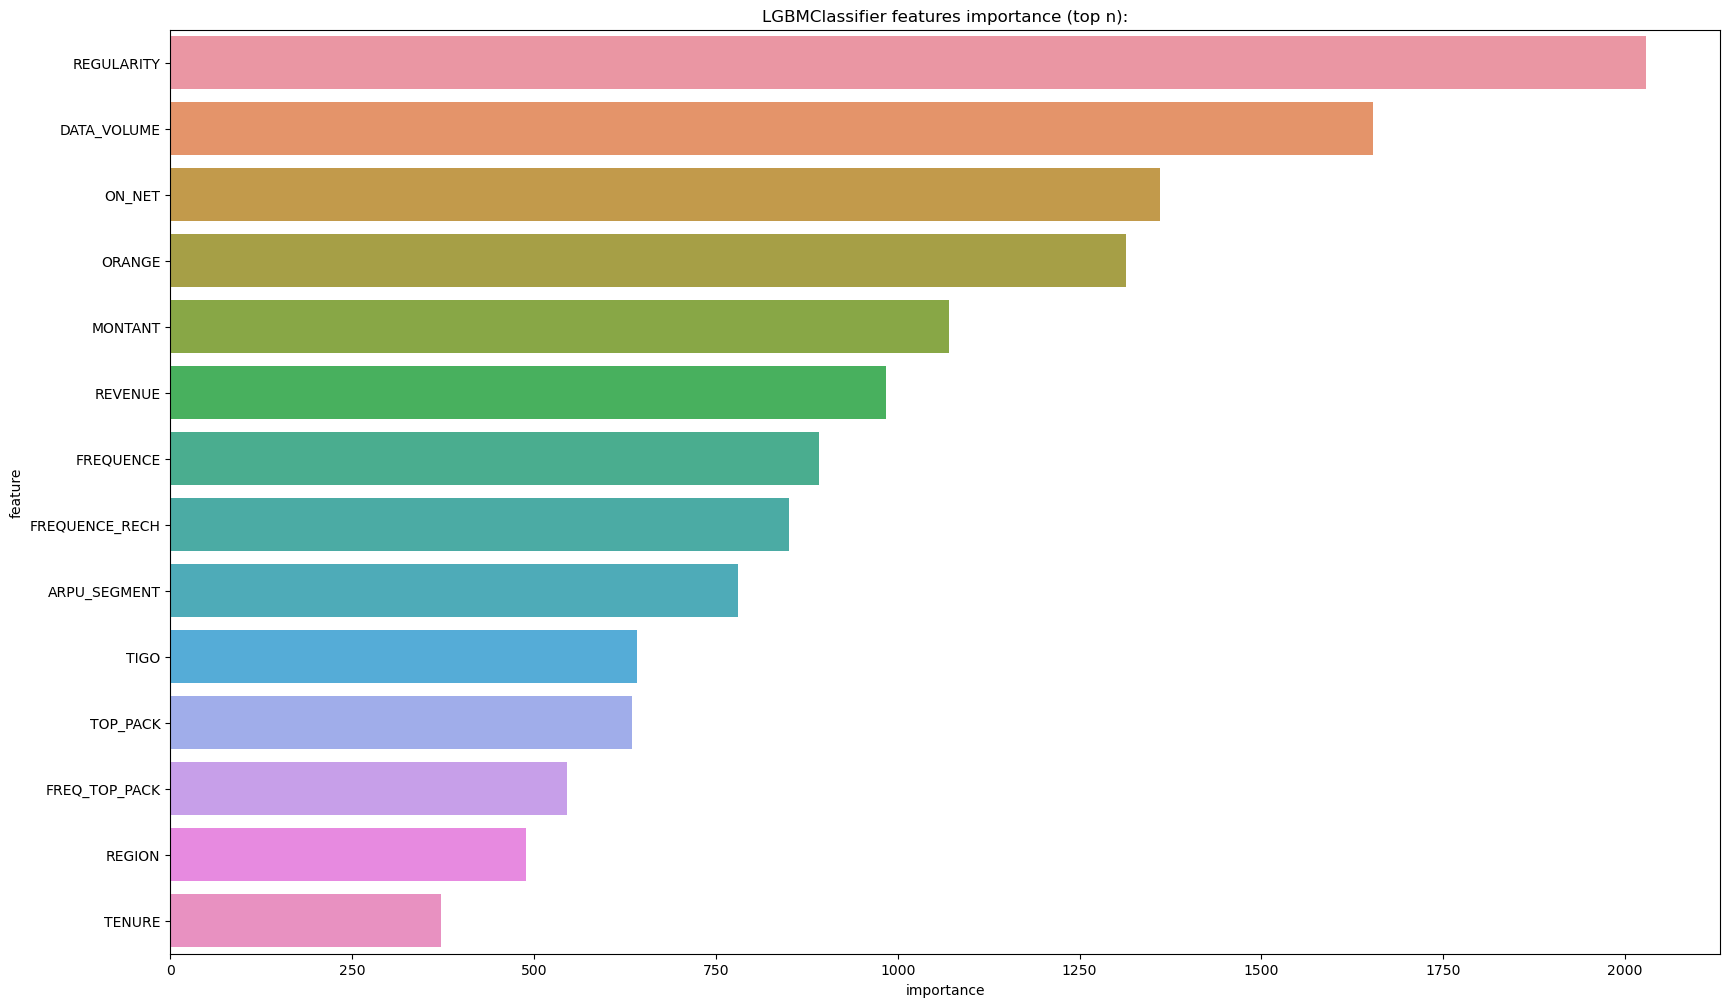

In [13]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = x_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('LGBMClassifier features importance (top n):');

In [15]:
train['TENURE']

0